In [457]:
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA

In [458]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [459]:
# pip install mediapipe

Read 1000 frames.
1000 frames saved to file.


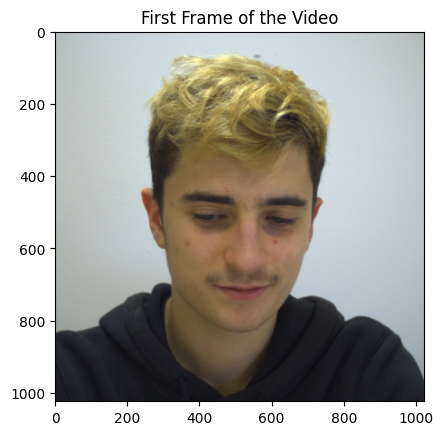

In [460]:
import cv2
import pickle
import os
import matplotlib.pyplot as plt

def read_video_frames(video_file, max_frames=1000):
    cap = cv2.VideoCapture(video_file)
    frames = []
    count = 0
    while count < max_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop if no frame is retrieved
        frames.append(frame)
        count += 1
    cap.release()
    print(f"Read {count} frames.")
    return frames

def display_first_frame(frames):
    if frames is not None and len(frames) > 0:
        frame_rgb = cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("First Frame of the Video")
        plt.show()
    else:
        print("No frame to display.")

def load_or_read_video_frames(video_path, frames_filename='saved_framess1t1.pkl', max_frames=1000):
    # Check if frames are already saved to a file
    if os.path.isfile(frames_filename):
        # If frames are saved, load them from the file
        with open(frames_filename, 'rb') as file:
            frames = pickle.load(file)
        print("Frames loaded from file.")
    else:
        # If frames are not saved, read and store video frames
        frames = read_video_frames(video_path, max_frames)
        # Save the frames to a file for future use
        with open(frames_filename, 'wb') as file:
            pickle.dump(frames, file)
        print(f"{len(frames)} frames saved to file.")
    return frames

video_path = 'dataset/s1/vid_s1_T1.avi'
frames_filename = 'saved_framess1t1.pkl'

frames = load_or_read_video_frames(video_path, frames_filename, max_frames=1000)
display_first_frame(frames)


In [461]:
len(frames)

1000

### Processed Frame with Face Mesh and Highlighted ROIs

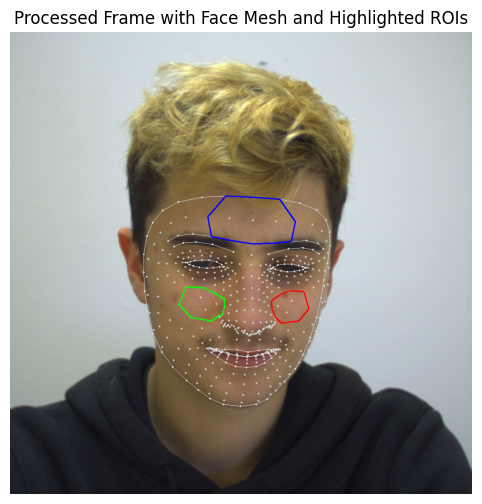

In [462]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Specify the drawing specifications for visualization
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
def process_frames_and_extract_roi_values(frames):
    processed_frames = []
    roi_signals = {'forehead': [], 'left_cheek': [], 'right_cheek': []}

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        for frame in frames:
            frame_copy = frame.copy()
            image_rgb = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
            results_mesh = face_mesh.process(image_rgb)

            if results_mesh.multi_face_landmarks:
                for face_landmarks in results_mesh.multi_face_landmarks:
                    # Drawing the facial landmarks for visualization
                    mp_drawing.draw_landmarks(frame_copy, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=drawing_spec, connection_drawing_spec=drawing_spec)

                    # For each ROI, calculate, store the mean pixel values, and draw the ROI
                    for name, indices in [('forehead', [107, 66, 69, 109, 10, 338, 299, 296, 336, 9]), 
                                          ('left_cheek', [118, 119, 100, 126, 209, 49, 129, 203, 205, 50]), 
                                          ('right_cheek', [347, 348, 329, 355, 429, 279, 358, 423, 425, 280])]:
                        # Extracting ROI pixels
                        roi_pixels = np.array([frame[int(face_landmarks.landmark[idx].y * frame.shape[0]), int(face_landmarks.landmark[idx].x * frame.shape[1])] for idx in indices])
                        mean_pixel_value = np.mean(roi_pixels, axis=0)
                        roi_signals[name].append(mean_pixel_value)

                        # Drawing ROI
                        points = np.array([[int(face_landmarks.landmark[idx].x * frame_copy.shape[1]), int(face_landmarks.landmark[idx].y * frame_copy.shape[0])] for idx in indices])
                        cv2.polylines(frame_copy, [np.array(points)], True, (255, 0, 0) if name == 'forehead' else (0, 255, 0) if name == 'left_cheek' else (0, 0, 255), 2)

            processed_frames.append(frame_copy)

    return processed_frames, roi_signals


processed_frames, roi_signals = process_frames_and_extract_roi_values(frames)

# Display one of the processed frames with ROIs
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(processed_frames[0], cv2.COLOR_BGR2RGB))
plt.title('Processed Frame with Face Mesh and Highlighted ROIs')
plt.axis('off')
plt.show()


In [463]:
print(f"Total frames read: {len(frames)}")

Total frames read: 1000


In [464]:
import pandas as pd

# Create DataFrame from roi_signals
roi_df = pd.DataFrame.from_dict(roi_signals)

# Save DataFrame to CSV
roi_df.to_csv('roi_signals.csv', index=False)


In [465]:
len(roi_signals.keys())

3

In [466]:
print(f"Number of ROIs: {len(roi_signals.keys())}")
for roi, values in roi_signals.items():
    print(f"{roi}: {values[:5]}")  # Print first 5 values for each ROI


Number of ROIs: 3
forehead: [array([ 74. , 102.6, 129.6]), array([ 75.5, 105.1, 133.4]), array([ 75.3, 103.8, 132.1]), array([ 74.6, 104.7, 131.5]), array([ 75.6, 102.8, 131.8])]
left_cheek: [array([ 79.3, 113.9, 152.7]), array([ 77.8, 113.6, 153. ]), array([ 81.1, 112.5, 153.5]), array([ 78.1, 112.6, 153.6]), array([ 79.3, 112.5, 153.2])]
right_cheek: [array([ 92.8, 120.6, 158.5]), array([ 93.4, 120.5, 159.2]), array([ 93.4, 120.8, 159.3]), array([ 93.6, 121.5, 158.4]), array([ 93.6, 121.9, 159.4])]


In [467]:
if len(frames) > 0:
    print(f"First frame shape: {frames[0].shape}, dtype: {frames[0].dtype}")
else:
    print("No frames to display.")


First frame shape: (1024, 1024, 3), dtype: uint8


In [468]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    if len(data) < 3 * order:
        print("Data too short for this order, considering padding or lowering order.")
        order = min(order, len(data) // 3)
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

fs = 35  
lowcut = 0.65
highcut = 4.0


# Convert lists of pixel values into numpy arrays
for roi, signals_list in roi_signals.items():
    roi_signals[roi] = np.array(signals_list)

filtered_signals = {}

for roi, signals in roi_signals.items():
    if signals.shape[0] > 1:
        filtered_signal = np.zeros_like(signals)
        for i in range(signals.shape[1]):  # Filtering channel-wise
            filtered_signal[:, i] = butter_bandpass_filter(signals[:, i], lowcut, highcut, fs, order=6)
        filtered_signals[roi] = filtered_signal
    else:
        print(f"Not enough data for filtering {roi}, skipping.")
        filtered_signals[roi] = signals

# Print the filtered_signals dictionary
print("Filtered Signals:")
for roi, signals in filtered_signals.items():
    print(f"ROI: {roi}, Filtered Signals Shape: {signals.shape}")

Filtered Signals:
ROI: forehead, Filtered Signals Shape: (1000, 3)
ROI: left_cheek, Filtered Signals Shape: (1000, 3)
ROI: right_cheek, Filtered Signals Shape: (1000, 3)


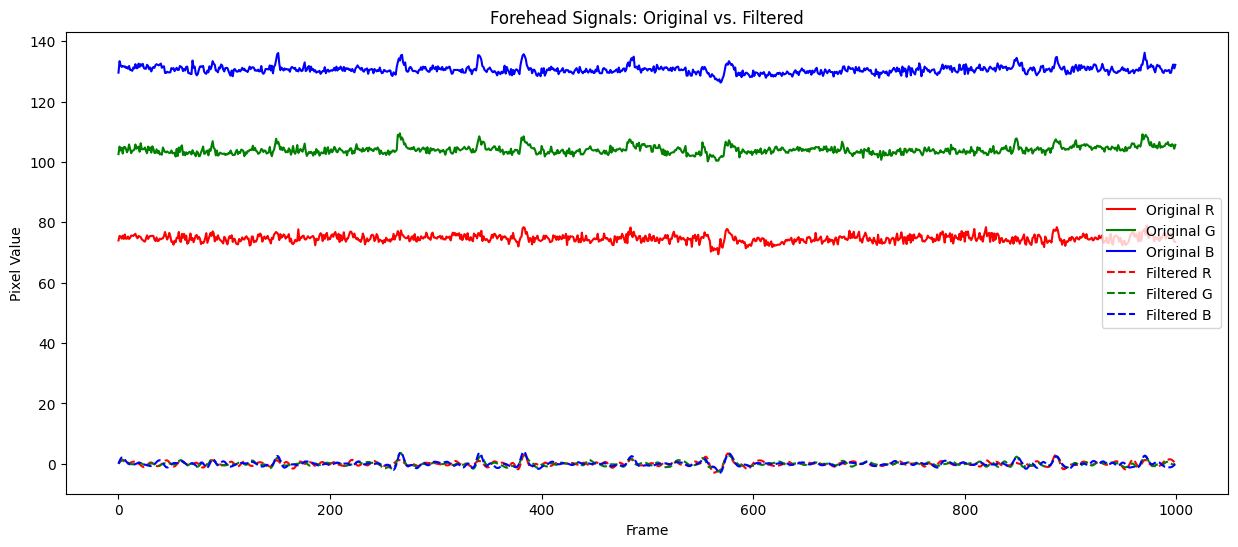

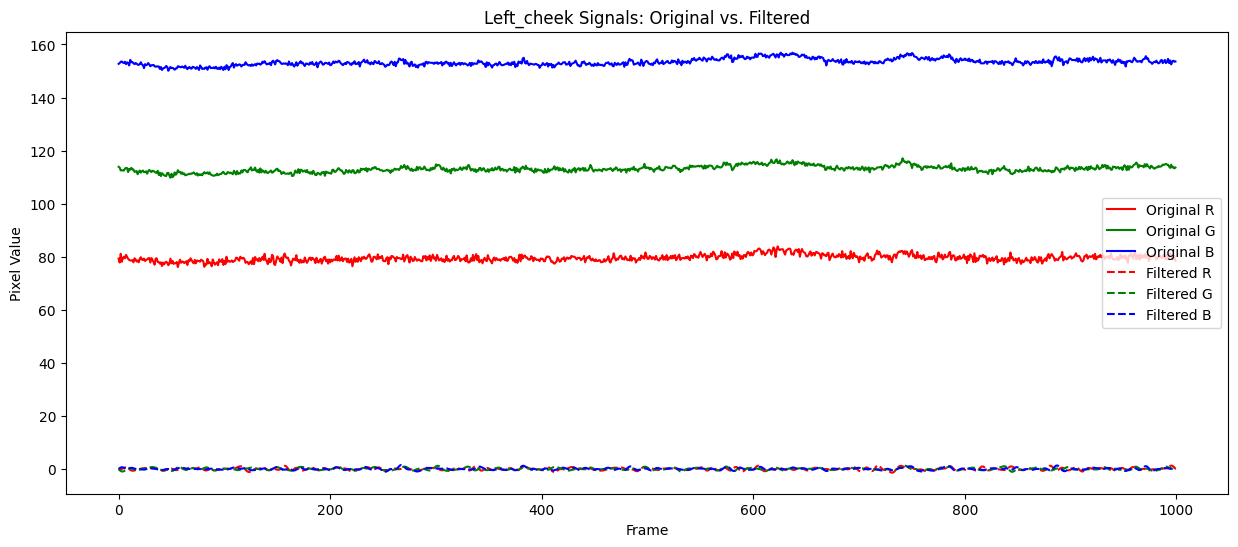

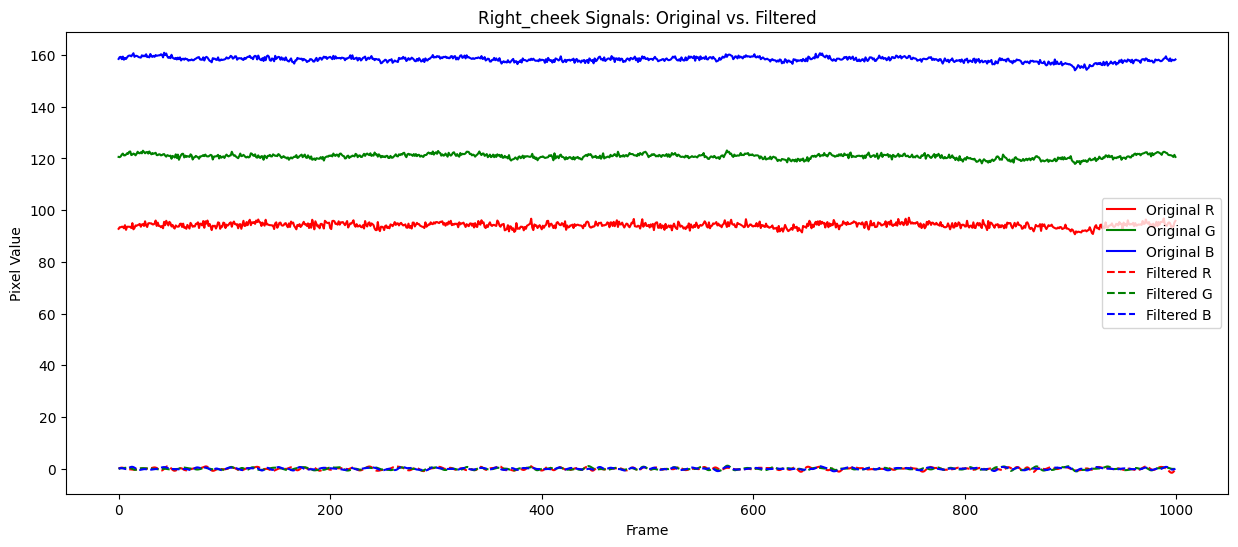

In [469]:
import matplotlib.pyplot as plt

def plot_signals(original_signals, filtered_signals, title):
    plt.figure(figsize=(15, 6))
    
    # Plotting the original signals
    plt.plot(original_signals[:, 0], 'r', label='Original R')
    plt.plot(original_signals[:, 1], 'g', label='Original G')
    plt.plot(original_signals[:, 2], 'b', label='Original B')
    
    # Plotting the filtered signals
    plt.plot(filtered_signals[:, 0], 'r--', label='Filtered R')
    plt.plot(filtered_signals[:, 1], 'g--', label='Filtered G')
    plt.plot(filtered_signals[:, 2], 'b--', label='Filtered B')
    
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.show()

processed_frames, roi_signals = process_frames_and_extract_roi_values(frames)

# Convert lists of pixel values into numpy arrays
for roi, signals_list in roi_signals.items():
    roi_signals[roi] = np.array(signals_list)

# Plot the signals before and after filtering for each ROI
for roi, original_signals in roi_signals.items():
    filtered_signals_roi = filtered_signals.get(roi)
    if filtered_signals_roi is not None:
        plot_signals(original_signals, filtered_signals_roi, f'{roi.capitalize()} Signals: Original vs. Filtered')
    else:
        print(f"No filtered signals available for {roi}. Skipping plotting.")


In [470]:
# Example diagnostic print for signals
for roi, signals in filtered_signals.items():
    print(f"{roi}: G Sample: {signals[:, 1][:5]}, R Sample: {signals[:, 0][:5]}, B Sample: {signals[:, 2][:5]}")


forehead: G Sample: [0.03162467 0.5396751  0.95526535 1.2140675  1.29667055], R Sample: [0.0387848  0.50935902 0.87555238 1.0650647  1.05732017], B Sample: [-0.00307907  0.93535382  1.67302981  2.07373436  2.10334369]
left_cheek: G Sample: [-0.04802727 -0.46132537 -0.78426524 -0.95481023 -0.9562268 ], R Sample: [-0.02754591 -0.10452878 -0.11131398 -0.01113469  0.1815219 ], B Sample: [-0.00960558  0.31645685  0.55434216  0.64770004  0.5916978 ]
right_cheek: G Sample: [0.00410833 0.10337277 0.18204096 0.23143192 0.2592829 ], R Sample: [0.0171378  0.23210418 0.38350479 0.4320457  0.37531213], B Sample: [0.04877592 0.17969618 0.25162576 0.23266314 0.13176795]


In [471]:
import random

# Print random values from filtered_signals
for roi, signals in filtered_signals.items():
    if signals.shape[0] > 1:
        random_index = random.randint(0, signals.shape[0] - 1)
        random_value = signals[random_index]
        print(f"ROI: {roi}, Random Value at Index {random_index}: {random_value}")
    else:
        print(f"No data for {roi}, skipping.")


ROI: forehead, Random Value at Index 482: [0.72784604 1.44563789 1.25538422]
ROI: left_cheek, Random Value at Index 881: [ 1.23053572 -0.5444659  -0.53582076]
ROI: right_cheek, Random Value at Index 434: [ 0.13544848 -0.28823101 -0.03816164]


In [472]:
type(filtered_signals)

dict

In [473]:
import pandas as pd

# Flatten the nested lists in filtered_signals dictionary
flattened_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in filtered_signals.items() for channel in ['R', 'G', 'B']}

# Create DataFrame from flattened dictionary
filtered_df = pd.DataFrame.from_dict(flattened_signals)

# Save DataFrame to CSV file
filtered_csv_path = 'filtered_signals.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered signals saved to {filtered_csv_path}")


Filtered signals saved to filtered_signals.csv


In [474]:
import pandas as pd

# Flatten the nested lists in filtered_signals dictionary
flattened_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in filtered_signals.items() for channel in ['R', 'G', 'B']}

# Create DataFrame from flattened dictionary
filtered_df = pd.DataFrame.from_dict(flattened_signals)

# Save DataFrame to CSV file
filtered_csv_path = 'filtered_signals.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered signals saved to {filtered_csv_path}")


Filtered signals saved to filtered_signals.csv


In [475]:
def plot_signals2(original_signals, filtered_signals, title):
    plt.figure(figsize=(15, 6))
    
    # Plotting the original signals
    plt.plot(original_signals[:, 0], 'r', label='Filtered R')
    
    # Plotting the filtered signals with an offset in the y-axis
    plt.plot(filtered_signals[:, 0] , 'r--', label='Detrended R (Offset)')
    
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.show()


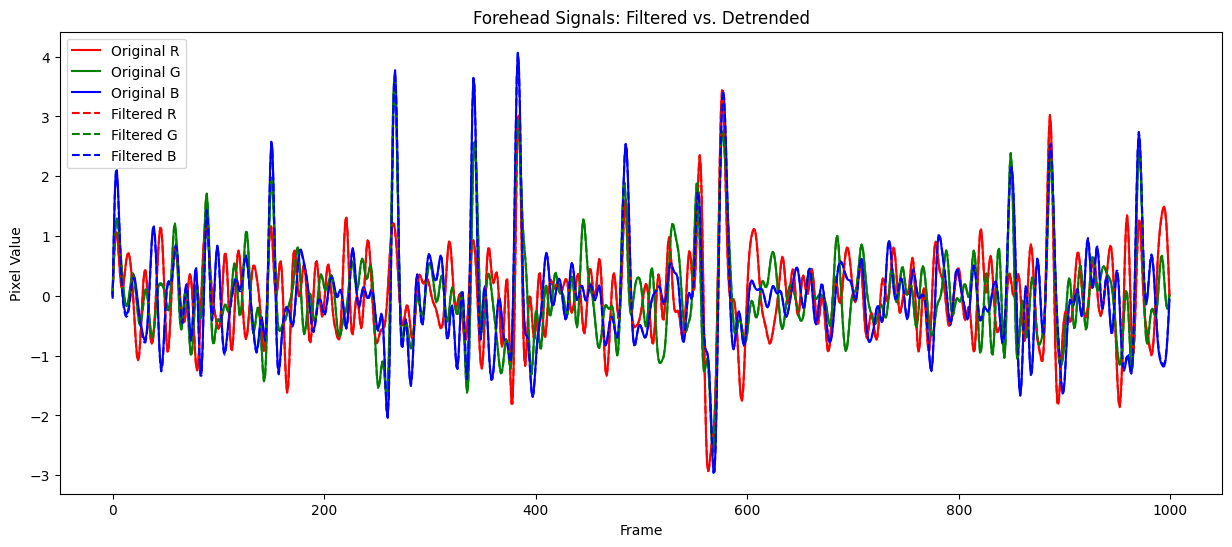

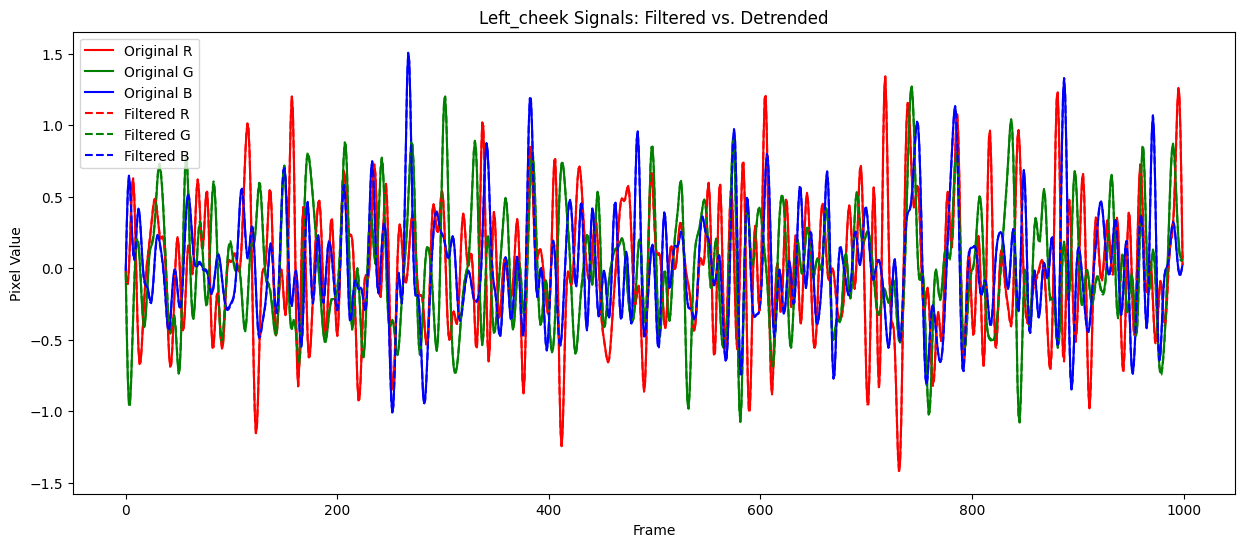

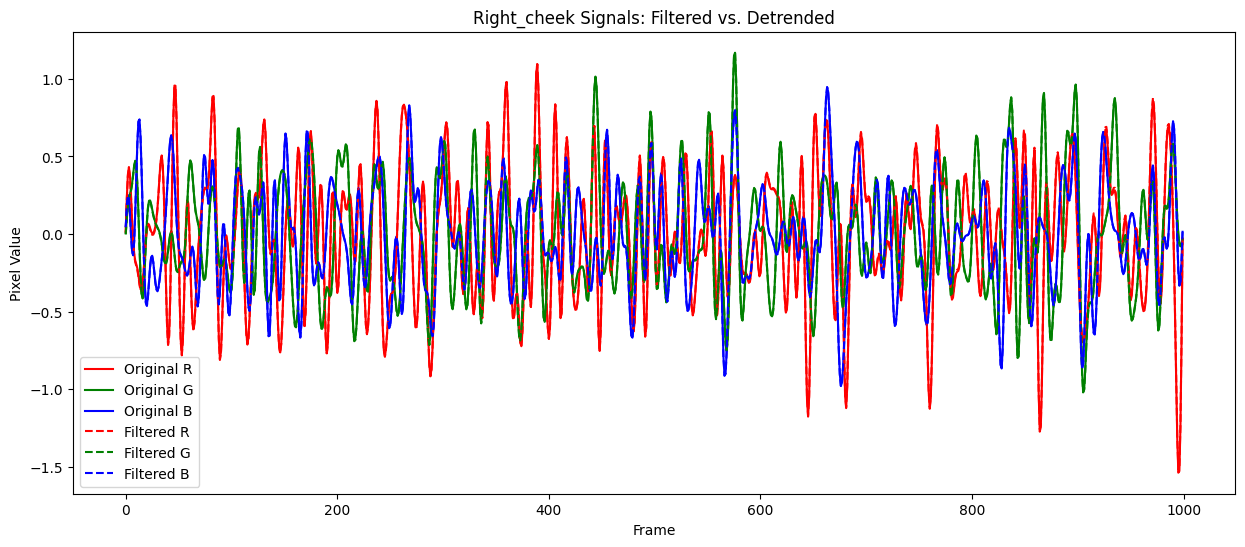

In [476]:
from scipy.signal import detrend

# Function to detrend the signals for each ROI
def detrend_roi_signals(filtered_signals):
    detrended_signals = {}
    for roi, signals in filtered_signals.items():
        detrended_signals[roi] = detrend(signals, axis=0)
    return detrended_signals

# Detrend the filtered signals for each ROI
detrended_signals = detrend_roi_signals(filtered_signals)

# Plot the detrended signals for each ROI
for roi, detrended_signal in detrended_signals.items():
    plot_signals(filtered_signals[roi], detrended_signal, f'{roi.capitalize()} Signals: Filtered vs. Detrended')


In [477]:
for roi, signals in detrended_signals.items():
    print(f"{roi}: {signals[:5]}")  # Print first 5 detrended values for each ROI


forehead: [[ 0.03237287  0.00967014 -0.04847641]
 [ 0.50293266  0.51774778  0.89003892]
 [ 0.8691116   0.93336524  1.62779734]
 [ 1.05860948  1.19219461  2.02858433]
 [ 1.05085052  1.27482487  2.0582761 ]]
left_cheek: [[-0.01925792 -0.02747961 -0.02071758]
 [-0.09626894 -0.44081611  0.30535805]
 [-0.10308231 -0.76379439  0.54325655]
 [-0.00293118 -0.93437778  0.63662763]
 [ 0.18969724 -0.93583276  0.58063859]]
right_cheek: [[ 0.00678674 -0.00090253  0.04460908]
 [ 0.22178197  0.09836374  0.17553297]
 [ 0.37321144  0.17703376  0.24746618]
 [ 0.4217812   0.22642654  0.22850719]
 [ 0.36507648  0.25427936  0.12761563]]


### Detrend the signals for each ROI

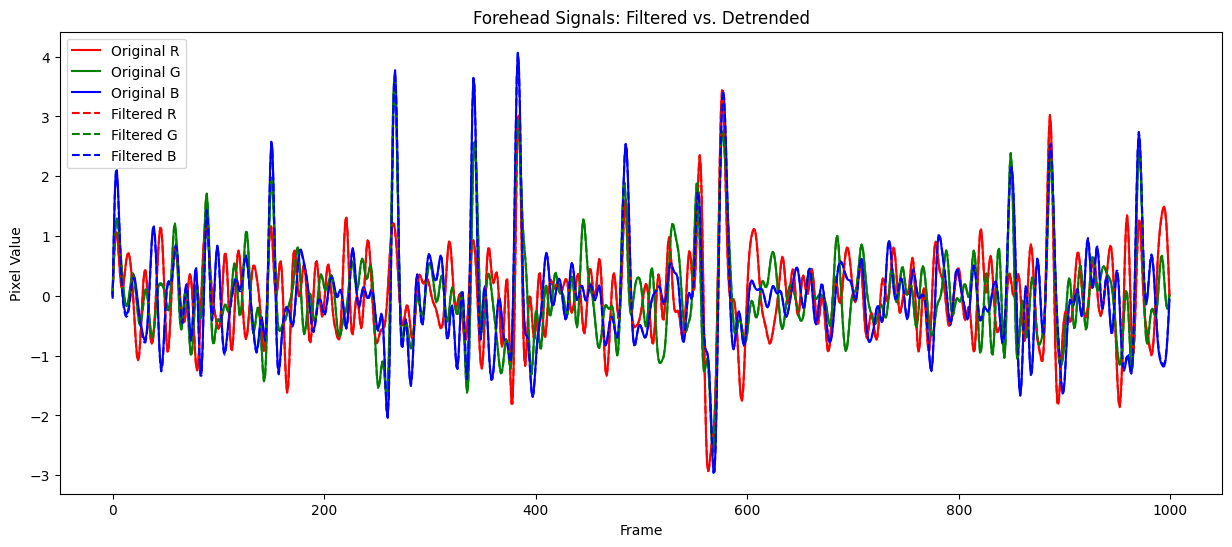

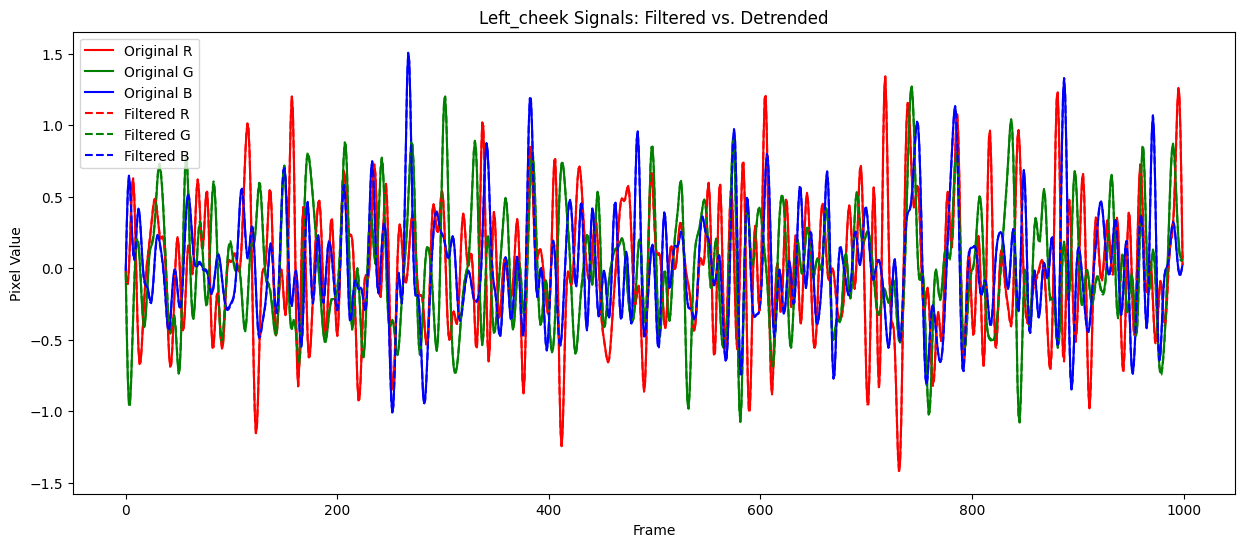

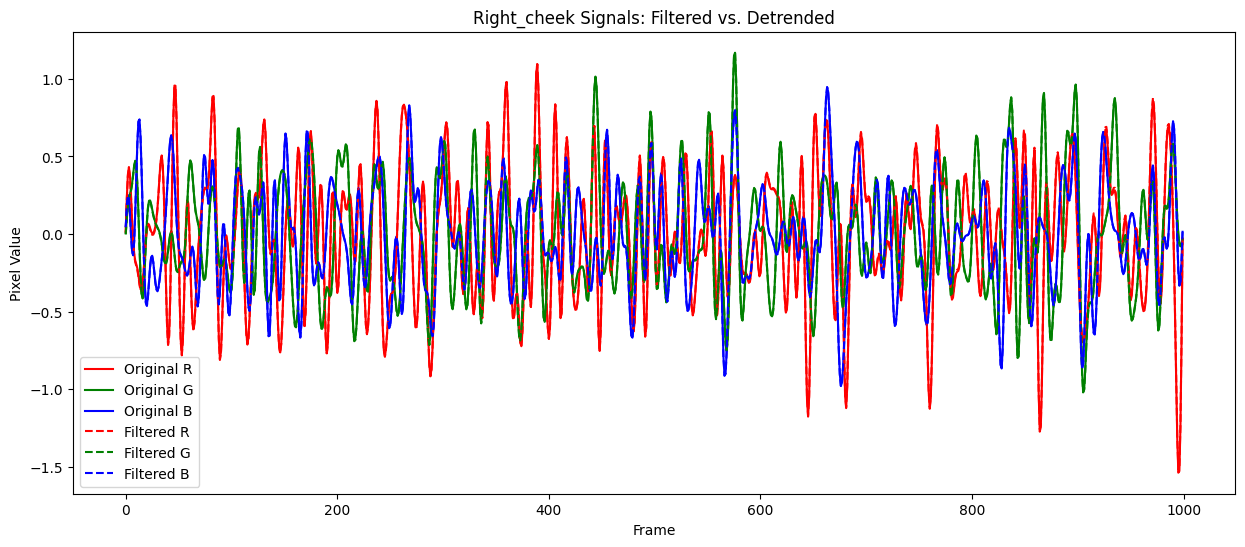

In [478]:
from scipy.signal import detrend

# Function to detrend the signals for each ROI
def detrend_roi_signals(filtered_signals):
    detrended_signals = {}
    for roi, signals in filtered_signals.items():
        detrended_signals[roi] = detrend(signals, axis=0)
    return detrended_signals

# Detrend the filtered signals for each ROI
detrended_signals = detrend_roi_signals(filtered_signals)

# Plot the detrended signals for each ROI
for roi, detrended_signal in detrended_signals.items():
    plot_signals(filtered_signals[roi], detrended_signal, f'{roi.capitalize()} Signals: Filtered vs. Detrended')


### Processed Frame with Face Mesh and Highlighted ROIs

In [479]:
for roi, signals in filtered_signals.items():
    print(f"{roi}, filtered sample: {signals[:5]}")  # Print first 5 filtered values for each ROI

forehead, filtered sample: [[ 0.0387848   0.03162467 -0.00307907]
 [ 0.50935902  0.5396751   0.93535382]
 [ 0.87555238  0.95526535  1.67302981]
 [ 1.0650647   1.2140675   2.07373436]
 [ 1.05732017  1.29667055  2.10334369]]
left_cheek, filtered sample: [[-0.02754591 -0.04802727 -0.00960558]
 [-0.10452878 -0.46132537  0.31645685]
 [-0.11131398 -0.78426524  0.55434216]
 [-0.01113469 -0.95481023  0.64770004]
 [ 0.1815219  -0.9562268   0.5916978 ]]
right_cheek, filtered sample: [[0.0171378  0.00410833 0.04877592]
 [0.23210418 0.10337277 0.17969618]
 [0.38350479 0.18204096 0.25162576]
 [0.4320457  0.23143192 0.23266314]
 [0.37531213 0.2592829  0.13176795]]


### Plot original vs. filtered signals for a specific ROI

### GRGB Calculation

In [480]:
flattened_detrend_signals = {roi + '_' + channel: [signal[i] for signal in signals for i in range(len(signal))] for roi, signals in detrended_signals.items() for channel in ['R', 'G', 'B']}

In [481]:
detrended_df = pd.DataFrame.from_dict(flattened_detrend_signals)

In [482]:
import numpy as np

def calculate_color_channel_ratios(detrended_df):
    ratios = {}
    for column_prefix in ['forehead', 'left_cheek', 'right_cheek']:
        R = detrended_df[f'{column_prefix}_R'].values
        G = detrended_df[f'{column_prefix}_G'].values
        B = detrended_df[f'{column_prefix}_B'].values
        GR_ratio = G / (R + 1e-6)  # Adding epsilon to avoid division by zero
        GB_ratio = G / (B + 1e-6)
        GRGB = GR_ratio + GB_ratio
        ratios[column_prefix] = GRGB  # Storing the time series GRGB ratio for each ROI
    
    return ratios

# Calculate the color channel ratios
color_channel_ratios = calculate_color_channel_ratios(detrended_df)


In [483]:
detrended_df.shape

(3000, 9)

In [484]:

from scipy.stats import mstats

def normalize_color_channel_ratios(color_channel_ratios):
    normalized_ratios = {}
    for roi, ratios in color_channel_ratios.items():
        if isinstance(ratios, np.ndarray):
            normalized_ratios[roi] = normalize_signal(ratios)
    return normalized_ratios

def normalize_signal(signal):
    # Winsorize the data to handle outliers
    winsorized_signal = mstats.winsorize(signal, limits=[0.05, 0.05])
    
    # Normalize the data to a [0, 1] range
    normalized_signal = (winsorized_signal - np.min(winsorized_signal)) / (np.max(winsorized_signal) - np.min(winsorized_signal))
    
    return normalized_signal

# Normalize the color channel ratios
normalized_color_channel_ratios = normalize_color_channel_ratios(color_channel_ratios)


In [485]:
from scipy.stats import zscore

def normalize_ratios(ratios):
    normalized_ratios = {}
    for roi, grgb in ratios.items():
        # Apply z-score normalization to mitigate the effect of outliers
        normalized_ratios[roi] = zscore(grgb)
    return normalized_ratios

normalized_ratios = normalize_ratios(color_channel_ratios)

# Display the first few normalized values of the GRGB ratio for each ROI to verify the normalization
for roi, grgb in normalized_ratios.items():
    print(f"{roi} first 5 normalized GRGB ratios: {grgb[:5]}")


forehead first 5 normalized GRGB ratios: [-0.26597414 -0.83813092  0.14053414 -0.03793005 -0.03748112]
left_cheek first 5 normalized GRGB ratios: [0.35261896 0.24578821 0.32746159 0.06699092 0.01116616]
right_cheek first 5 normalized GRGB ratios: [-0.64292482  4.63260073 -0.11851101 -0.0433279  -0.06707966]


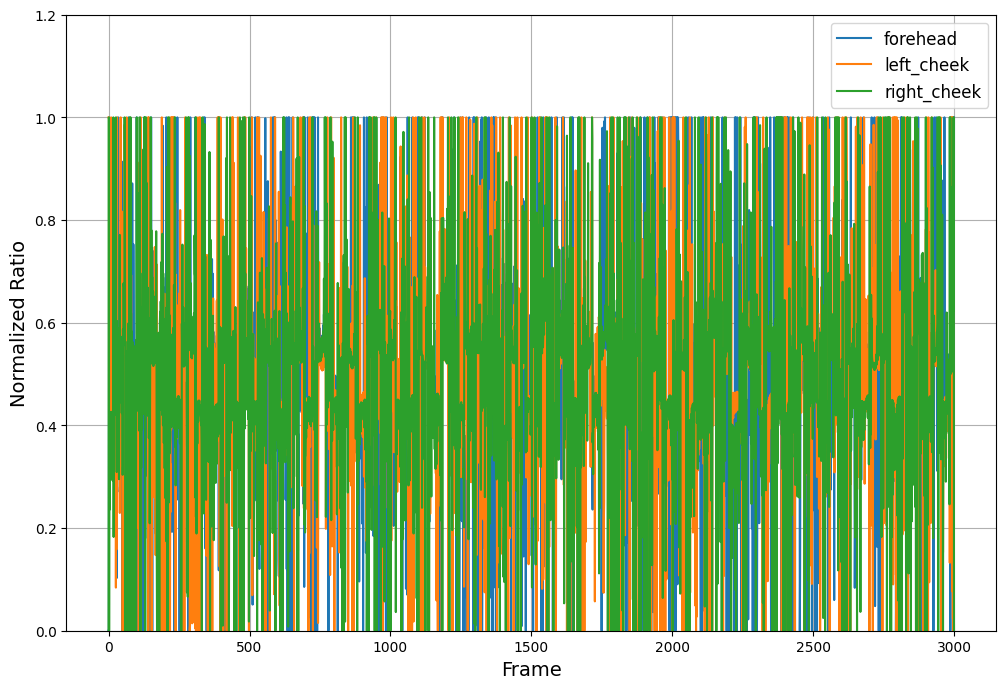

In [486]:
# Plot the normalized color channel ratios
plt.figure(figsize=(12, 8))  # Increase figure size
for roi, ratios in normalized_color_channel_ratios.items():
    plt.plot(ratios, label=roi)

# plt.title('Normalized Color Channel Ratios Over Time', fontsize=16) 
plt.xlabel('Frame', fontsize=14)  
plt.ylabel('Normalized Ratio', fontsize=14) 
plt.legend(fontsize=12) 
plt.grid(True)
plt.ylim(0, 1.2) 
plt.show()


In [487]:
df_normalized_ratios = pd.DataFrame(normalized_color_channel_ratios)
df_normalized_ratios.to_csv('normalized_color_channel_ratios.csv', index=False)

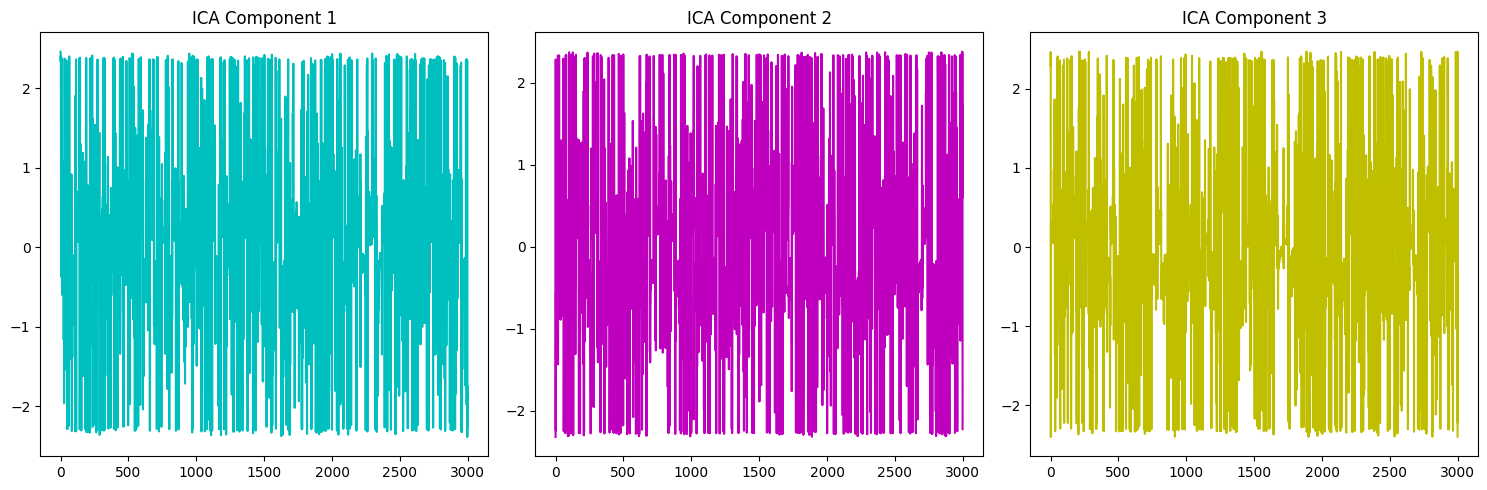

In [488]:
from sklearn.decomposition import FastICA

X = df_normalized_ratios.values

# Initialize and apply ICA
ica = FastICA(n_components=3, random_state=0)
S_ = ica.fit_transform(X) 
A_ = ica.mixing_ 

# Plot the independent components to identify the one most representative of the heart pulse
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, (component, color) in enumerate(zip(S_.T, ['c', 'm', 'y']), start=1):
    plt.subplot(1, 3, i)
    plt.plot(component, color=color)
    plt.title(f'ICA Component {i}')
plt.tight_layout()
plt.show()


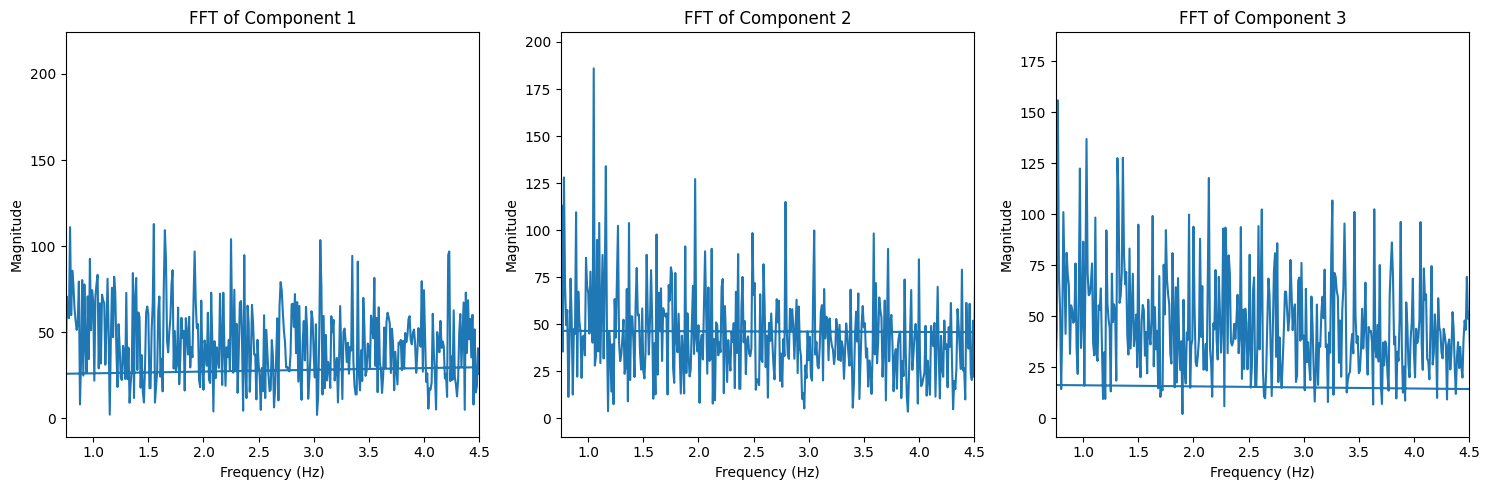

In [489]:
from scipy.fft import fft, fftfreq

fs = 30 
import numpy as np

# Compute the FFT and corresponding frequencies for each component again
fft_components = [fft(component) for component in S_.T]
freqs = fftfreq(X.shape[0], 1/fs)

# Plot the magnitude of the FFT for each component within the heart rate range (0.75 Hz to 4.5 Hz)
plt.figure(figsize=(15, 5))
for i, fft_component in enumerate(fft_components, start=1):
    plt.subplot(1, 3, i)
    plt.plot(freqs, np.abs(fft_component))
    plt.xlim(0.75, 4.5)  # Limit x-axis to target heart rate range
    plt.title(f'FFT of Component {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


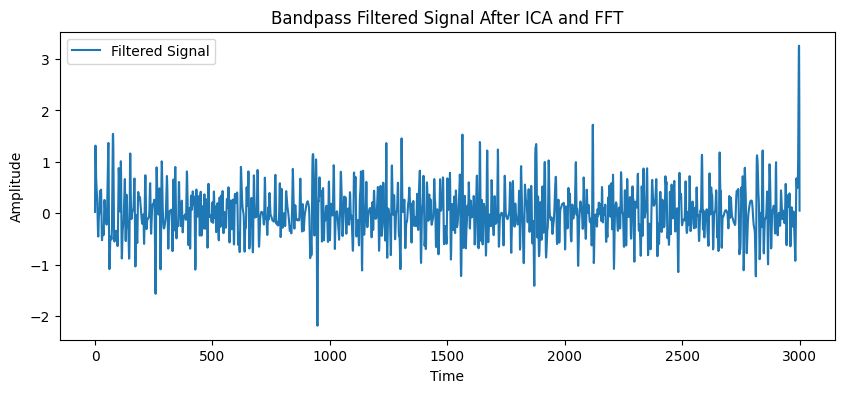

In [490]:
from scipy.signal import butter, filtfilt

# Function to design a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply a bandpass filter to a signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

most_representative_component = S_[:, 1]  # Second ICA component selected

# Define heart rate range in Hz (45 bpm to 270 bpm)
lowcut = 45 / 60.0
highcut = 270 / 60.0

# Apply bandpass filter to the most representative component
filtered_signal = butter_bandpass_filter(most_representative_component, lowcut, highcut, fs, order=2)

# Plot the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.title('Bandpass Filtered Signal After ICA and FFT')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


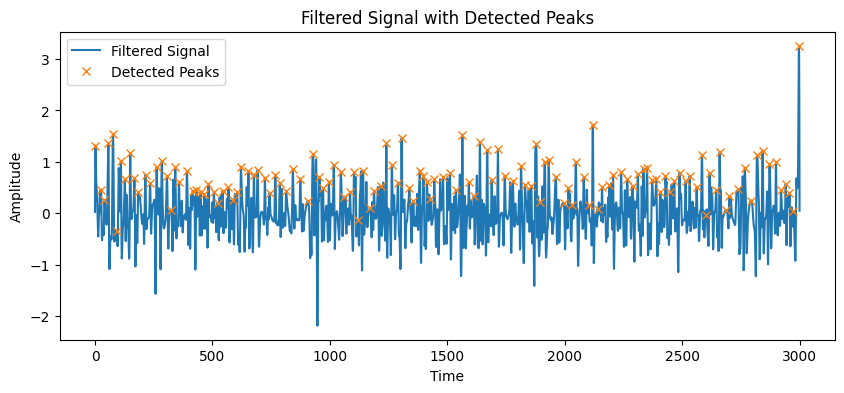

79.93322203672787

In [491]:
from scipy.signal import find_peaks

# Detect peaks in the filtered signal
peaks, _ = find_peaks(filtered_signal, distance=fs*0.5) 

# Calculate IBIs (Interbeat Intervals) in seconds
ibis = np.diff(peaks) / fs

# Calculate the average heart rate
if ibis.size > 0:
    avg_ibi = np.mean(ibis)
    heart_rate = 60 / avg_ibi  # Convert IBIs to heart rate in beats per minute (bpm)
else:
    heart_rate = 0  # No peaks detected, indicating no heart rate could be calculated

# Plot the filtered signal with detected peaks
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.plot(peaks, filtered_signal[peaks], "x", label='Detected Peaks')
plt.title('Filtered Signal with Detected Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

heart_rate

In [492]:
# Convert IBIs to a DataFrame for export
ibi_df = pd.DataFrame(ibis, columns=['IBI'])

# Save the IBI time series to a CSV file
ibi_csv_path = 'ibi_time_series.csv'
ibi_df.to_csv(ibi_csv_path, index=False)

ibi_csv_path

'ibi_time_series.csv'

### Validation based on Supplied BVP data with original UBFC-Phys dataset 

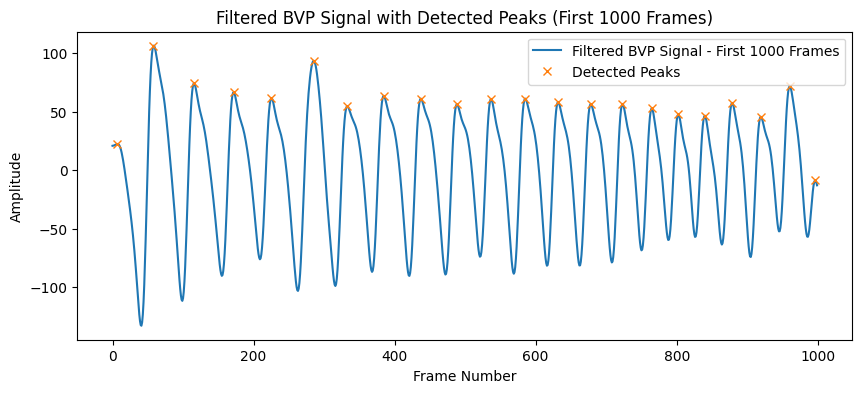

(81.53690596562184, array([0.796875, 0.90625 , 0.875   , 0.828125, 0.9375  ]))

In [493]:
bvp_path = 'dataset/s1/bvp_s1_T1.csv'

bvp_df = pd.read_csv(bvp_path)

fs_bvp = 64  # Hz, the sampling rate for BVP signals

# Redo the analysis using the first 1000 frames of the BVP data
filtered_bvp_signal_1000 = butter_bandpass_filter(bvp_df.values.flatten()[:1000], 0.5, 3.5, fs_bvp, order=2)

# Detect peaks in the filtered BVP signal limited to first 1000 frames
peaks_bvp_1000, _ = find_peaks(filtered_bvp_signal_1000, distance=fs_bvp*0.5)

# Calculate IBIs from BVP signal
ibis_bvp_1000 = np.diff(peaks_bvp_1000) / fs_bvp

# Calculate average heart rate from IBIs
if ibis_bvp_1000.size > 0:
    avg_heart_rate_bvp_1000 = 60 / np.mean(ibis_bvp_1000)
else:
    avg_heart_rate_bvp_1000 = 0  # No IBIs

# Plot the filtered BVP signal with detected peaks for visualization
plt.figure(figsize=(10, 4))
plt.plot(filtered_bvp_signal_1000, label='Filtered BVP Signal - First 1000 Frames')
plt.plot(peaks_bvp_1000, filtered_bvp_signal_1000[peaks_bvp_1000], "x", label='Detected Peaks')
plt.title('Filtered BVP Signal with Detected Peaks (First 1000 Frames)')
plt.xlabel('Frame Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

avg_heart_rate_bvp_1000, ibis_bvp_1000[:5]  # Show the average heart rate and the first few IBIs for reference


In [494]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend, find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import zscore

class HeartMetricsCalculator:
    def __init__(self, fs=30):
        self.fs = fs

    @staticmethod
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    @staticmethod
    def compute_IBI(peaks, fs):
        return np.diff(peaks) / fs

    @staticmethod
    def calculate_baevsky_stress_index(ibi):
        hist, bin_edges = np.histogram(ibi, bins=np.arange(0, max(ibi) + 0.05, 0.05))
        amplitude = np.max(hist) / len(ibi)
        sdnn = np.std(ibi)
        bsi = amplitude / (2 * 3.92 * sdnn) * 10
        return bsi

    def calculate_hrv_metrics(self, ibi):
        sdnn = np.std(ibi)
        rmssd = np.sqrt(np.mean(np.square(np.diff(ibi))))
        bsi = self.calculate_baevsky_stress_index(ibi)
        frequencies = fftfreq(len(ibi), d=np.mean(ibi) if len(ibi) > 0 else 0)
        power_spectrum = np.abs(fft(ibi))**2
        lf_band = (0.04, 0.15)
        hf_band = (0.15, 0.4)
        lf_power = np.sum(power_spectrum[(frequencies >= lf_band[0]) & (frequencies < lf_band[1])])
        hf_power = np.sum(power_spectrum[(frequencies >= hf_band[0]) & (frequencies < hf_band[1])])
        lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan
        return sdnn, rmssd, bsi, lf_hf_ratio


### HRV Metrics Comparison

In [495]:
# Initialize calculators for both datasets
fs_current = 30
calculator_current = HeartMetricsCalculator(fs=fs_current)
fs_bvp = 64
calculator_bvp = HeartMetricsCalculator(fs=fs_bvp)

# Calculate HRV metrics for both datasets
sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current = calculator_current.calculate_hrv_metrics(ibis)
sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp = calculator_bvp.calculate_hrv_metrics(ibis_bvp_1000)

# Calculate average heart rates from IBIs
avg_heart_rate_current = 60 / np.mean(ibis) if ibis.size > 0 else 0
avg_heart_rate_bvp_1000 = 60 / np.mean(ibis_bvp_1000) if ibis_bvp_1000.size > 0 else 0

# Display the HRV metrics and heart rates for both methods
hrv_metrics_comparison = pd.DataFrame({
    'Metric': ['Heart Rate', 'SDNN', 'RMSSD', 'BSI', 'LF/HF Ratio'],
    'Current Calculation': [avg_heart_rate_current, sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current],
    'BVP Dataset Calculation': [avg_heart_rate_bvp_1000, sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp]
})

print(hrv_metrics_comparison)

        Metric  Current Calculation  BVP Dataset Calculation
0   Heart Rate            79.933222                81.536906
1         SDNN             0.198726                 0.106511
2        RMSSD             0.281695                 0.064707
3          BSI             1.206472                 2.851292
4  LF/HF Ratio             0.631975                 6.962535


In [496]:
from datetime import datetime

current_metrics = hrv_metrics_comparison[['Metric', 'Current Calculation']].copy()
current_metrics['Timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print(current_metrics)
current_metrics.rename(columns={'Current Calculation': 'Calculation'}, inplace=True)
# Generate a new filename each time
filename = f"hrv_metrics_{np.random.randint(1000)}.csv"


# Save the DataFrame as CSV
current_metrics.to_csv(filename, index=False)
current_metrics

,Metric,Calculation,Timestamp
0,Heart Rate,79.933222,2024-02-08 11:35:11
1,SDNN,0.198726,2024-02-08 11:35:11
2,RMSSD,0.281695,2024-02-08 11:35:11
3,BSI,1.206472,2024-02-08 11:35:11
4,LF/HF Ratio,0.631975,2024-02-08 11:35:11


In [497]:
current_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Metric       5 non-null      object 
 1   Calculation  5 non-null      float64
 2   Timestamp    5 non-null      object 
dtypes: float64(1), object(2)
memory usage: 248.0+ bytes


# Statistial analysis

In [498]:
from scipy.stats import ttest_rel, wilcoxon

# Perform paired t-test and Wilcoxon signed-rank test on the metrics
# Wilcoxon test is used as a non-parametric alternative to the paired t-test

# Convert metrics to numpy arrays for statistical testing
previous_metrics = np.array([sdnn_current, rmssd_current, bsi_current, lf_hf_ratio_current])
bvp_metrics = np.array([sdnn_bvp, rmssd_bvp, bsi_bvp, lf_hf_ratio_bvp])

# Paired t-test
t_test_stat, t_test_p = ttest_rel(previous_metrics, bvp_metrics)

# Wilcoxon signed-rank test
wilcoxon_stat, wilcoxon_p = wilcoxon(previous_metrics, bvp_metrics)

t_test_stat, t_test_p, wilcoxon_stat, wilcoxon_p


(-1.2514490027725682, 0.29946930606165384, 3.0, 0.625)

In [499]:
# These statistical tests suggest that there are no statistically significant differences between the two sets of HRV metrics at the conventional alpha level of 0.05. The p-values indicate that the observed differences in HRV metrics could likely be due to random variation rather than systematic differences between the methodologies used to calculate them.

In [500]:
# First, let's load the provided data into a DataFrame to understand its structure
import pandas as pd

# Load the data from the uploaded CSV file
df = pd.read_csv('HRV results ASEE June.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()


,Session,Metric,Current Calculation,BVP Dataset Calculation
0,S1 video 1,Heart Rate,73.383215,81.536906
1,S1 video 1,SDNN,0.101185,0.106511
2,S1 video 1,RMSSD,0.071178,0.064707
3,S1 video 1,BSI,2.993857,2.851292
4,S1 video 1,LF/HF Ratio,6.614408,6.962535


In [501]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize dictionaries to hold the calculation results for each metric
mae_results = {}
rmse_results = {}
correlation_results = {}

# Iterate over each unique metric in the dataset
for metric in df['Metric'].unique():
    # Filter the dataframe for the current metric
    metric_df = df[df['Metric'] == metric]
    
    # Calculate MAE
    mae = mean_absolute_error(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation'])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation']))
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(metric_df['Current Calculation'], metric_df['BVP Dataset Calculation'])[0, 1]
    
    # Store the results in the dictionaries
    mae_results[metric] = mae
    rmse_results[metric] = rmse
    correlation_results[metric] = correlation

# Convert the results to DataFrames for better visualization
mae_df = pd.DataFrame(list(mae_results.items()), columns=['Metric', 'MAE'])
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Metric', 'RMSE'])
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Metric', 'Correlation'])

(mae_df, rmse_df, correlation_df)


(        Metric       MAE
 0   Heart Rate  6.070497
 1         SDNN  0.014063
 2        RMSSD  0.012564
 3          BSI  0.192126
 4  LF/HF Ratio  0.217481,
         Metric      RMSE
 0   Heart Rate  6.436406
 1         SDNN  0.015694
 2        RMSSD  0.013933
 3          BSI  0.240964
 4  LF/HF Ratio  0.296022,
         Metric  Correlation
 0   Heart Rate     0.926160
 1         SDNN     0.966014
 2        RMSSD     0.988361
 3          BSI     0.989345
 4  LF/HF Ratio     0.998480)